Data analisys for kaggle ship dataset 

In [4]:
import pandas as pd
import config as conf

df = pd.read_csv(conf.CSV_FILE)

df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Count and percent of images without ships:

In [5]:
image_ids = df["ImageId"]
encoded_pixels = df["EncodedPixels"]

size = len(df)

print(f"Number of empty ImageId values - {image_ids.isna().sum()}")
print(f"Number of empty EncodedPixel values - {encoded_pixels.isna().sum()}")

print(f"Percent of empty ImageId values - {image_ids.isna().sum() / size * 100}%")
print(f"Percent of empty EncodedPixel values - {encoded_pixels.isna().sum() / size * 100:.2f}%")


Number of empty ImageId values - 0
Number of empty EncodedPixel values - 149999
Percent of empty ImageId values - 0.0%
Percent of empty EncodedPixel values - 64.73%


Doing analysis on all data is time consuming, so the better way is to use some smaller sample

In [6]:
sample = df.sample(frac=0.1)

Find truncated images:

In [7]:
from PIL import Image
from os.path import join


def is_truncated_image(image_id):
    try:
        Image.open(join(conf.IMAGES_DIR, image_id)).load()
    except OSError as e:
        print(e, image_id)
        return True
    return False 

In [26]:
n_truncated = sample["ImageId"].apply(is_truncated_image).sum()

print(f"The sum of truncated images in a sample - {n_truncated}")

The sum of truncated images - 0


In [10]:
df["truncated"] = df["ImageId"].apply(is_truncated_image)

print(f"Truncated images in whole dataframe - {df['truncated'].sum()}")
df["truncated"].head()

image file is truncated (51 bytes not processed) 6384c3e78.jpg


KeyboardInterrupt: 

There is a single truncated image with id 6384c3e78.jpg. So we need to delete this from dataset

In [12]:
trunc_image = "6384c3e78.jpg"
df = df[df["ImageId"] != trunc_image]

In [18]:
df.to_csv(conf.CSV_FILE, sep=',', index=False)

Plotting color distributions

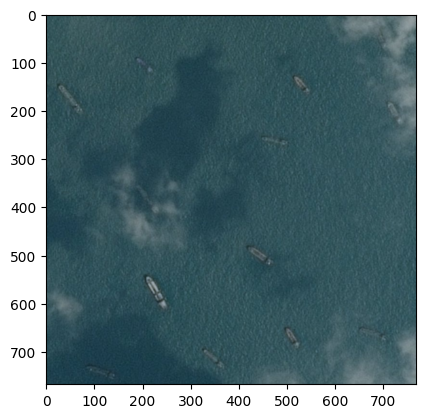

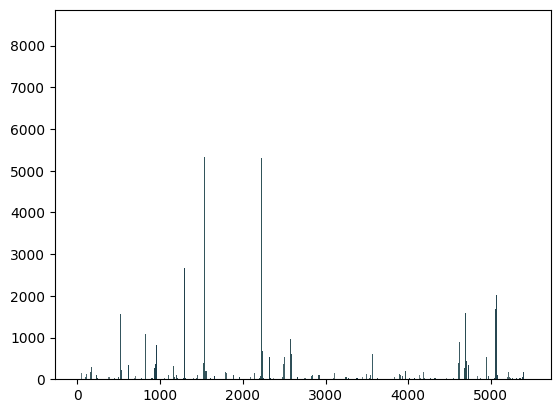

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)


image_index = randint(0, len(df))

im = Image.open(join(conf.IMAGES_DIR, df["ImageId"][image_index]))  
w, h = im.size  
colors = im.getcolors(w*h)

plt.imshow(im)
plt.show()

for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]))

plt.show()